## Gael Blanchard
###  Problem: Given the Global Terrorism Data Set construct a predictive model which can determine which terrorist group is responsible for an event

## Global Terrorism Data
[Source: National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2016). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd](http://www.start.umd.edu/gtd)

In [1]:
#Required Libraries
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, hamming_loss
import matplotlib.pyplot as plt

In [2]:
#Disables SettingWithCopy Warning
pd.options.mode.chained_assignment = None
#Set the random seed for reproducible results
np.random.seed(0)

In [3]:
#Method to determine the performance of our classification models
#Does a simple comparison of predicitons and actual calculations
def print_results(predictions,data,desired_variable):
	print("Results:")
	print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
	.format(
		data.shape[0],
		(data[desired_variable] != predictions).sum(),
		100*(1-(data[desired_variable] != predictions).sum()/data.shape[0])
		)
	)
    
#method to return the head and tail frequencies
def frequency_data(data,factors):
    for factor in factors:
        print(factor)
        print(data[factor].value_counts().head())
        #print(data[factor].value_counts().tail())

# 1.   Data Collection
* Read in our data from the Global Terrorism Database into a Pandas Data Frame
* Isolated the variables we needed (10/135 available)

In [11]:
#Isolated features for use in our classification models
#at Data Collection stage to lower memory usage
factors_list = ["gname","iyear","country","attacktype1","targtype1","weaptype1","multiple","success","suicide","city"]
global_terrorism_data = pd.read_excel("globalterrorismdb_0617dist.xlsx")

In [13]:
#Describe the data we have just read in
global_terrorism_data = global_terrorism_data[factors_list]
global_terrorism_data.describe(include="all")

,gname,iyear,country,attacktype1,targtype1,weaptype1,multiple,success,suicide,city
count,170350,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,169904
unique,3454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33957
top,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
freq,78306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9162
mean,NaN,2001.709997,132.526669,3.220211,8.399654,6.428576,0.134206,0.896396,0.033871,NaN
std,NaN,13.144146,112.848161,1.891227,6.648615,2.152366,0.340875,0.304747,0.180899,NaN
min,NaN,1970.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,1990.000000,75.000000,2.000000,3.000000,5.000000,0.000000,1.000000,0.000000,NaN
50%,NaN,2007.000000,98.000000,3.000000,4.000000,6.000000,0.000000,1.000000,0.000000,NaN
75%,NaN,2014.000000,160.000000,3.000000,14.000000,6.000000,0.000000,1.000000,0.000000,NaN


[This website](http://www.start.umd.edu/gtd/downloads/Codebook.pdf) provides a detail explanation of all the features in the GTD. Given the explanation within the booklet, we can isolate certain features. For example, when considering a variable for time year is the most complete whereas month and day can have 0 values when unknown. This booklet also allowed the omission of feature engineering for variables such as country_txt, attacktype1_txt, targtype1_txt, and weaptype1_txt because it has associated numerical codes which serve as factors within this program.

 Logic behind selecting these features:
*  Minimal imputation (All of our features with the exception of city are complete for all rows)
* Complete features within our data allow for logical subsets within the data which is optimal for prediciton
* Prevent overfitting


# 2. Data Preparation & Exploration
* Searched for NA data within our data
* Determined the frequency of every variable besides year
* Factorized city and gname variables for usage in our predictive models
* Seperated data into known and unknown perpetrators
* Defined our train and test sets

In [14]:
#Look for missing data
missing_data = global_terrorism_data.isna().any()
print(missing_data)
#Recognize that our city variable has null values
#All of our data is categorical in nature
freq_factors = ["gname","country","attacktype1","targtype1","weaptype1","multiple","success","suicide","city"]
#Frequency
frequency_data(global_terrorism_data,freq_factors)

gname          False
iyear          False
country        False
attacktype1    False
targtype1      False
weaptype1      False
multiple       False
success        False
suicide        False
city            True
dtype: bool
gname
Unknown                                             78306
Taliban                                              6575
Shining Path (SL)                                    4551
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Name: gname, dtype: int64
country
95     22130
153    13634
4      11306
92     10978
45      8163
Name: country, dtype: int64
attacktype1
3    83073
2    40223
1    18402
6    10233
7     9581
Name: attacktype1, dtype: int64
targtype1
14    39994
4     25508
3     22938
2     20314
1     19873
Name: targtype1, dtype: int64
weaptype1
6     86704
5     55273
13    13852
8     10459
9      3338
Name: weaptype1, dtype: int64
multiple
0    147488
1     22862
Name: multiple, dtype: 

Note: There are several classes with single instances

In [15]:
#Factorizing data will remove the missing data and seperate city into classes
#Key if we want to determine the associated perpreatator after running a prediction
key_names = global_terrorism_data["gname"].unique()
for_factor_key_names = key_names
key_id = pd.factorize(for_factor_key_names)[0]
#We also factorize our variable to predict (Perpetrator Group Name)
global_terrorism_data["city"] = pd.factorize(global_terrorism_data["city"])[0]
global_terrorism_data["gname"] = pd.factorize(global_terrorism_data["gname"])[0]
#Training and Test Data Sets
training_data = global_terrorism_data
test_data = global_terrorism_data.sample(frac=0.8, replace=False)
test_unknown = global_terrorism_data[global_terrorism_data["gname"] == 2]
#list of factors to use for prediction
predictor_factors = ["iyear","country","attacktype1","targtype1","weaptype1","multiple","success","suicide","city"]

In [16]:
#Looking at our data post preparation
#Notice now that our data is now fully representated as numerical values
global_terrorism_data.describe()

,gname,iyear,country,attacktype1,targtype1,weaptype1,multiple,success,suicide,city
count,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000
mean,738.418855,2001.709997,132.526669,3.220211,8.399654,6.428576,0.134206,0.896396,0.033871,8829.739249
std,1053.472803,13.144146,112.848161,1.891227,6.648615,2.152366,0.340875,0.304747,0.180899,9488.356110
min,0.000000,1970.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.000000,1990.000000,75.000000,2.000000,3.000000,5.000000,0.000000,1.000000,0.000000,547.000000
50%,46.000000,2007.000000,98.000000,3.000000,4.000000,6.000000,0.000000,1.000000,0.000000,4670.000000
75%,1278.000000,2014.000000,160.000000,3.000000,14.000000,6.000000,0.000000,1.000000,0.000000,16100.750000
max,3453.000000,2016.000000,1004.000000,9.000000,22.000000,13.000000,1.000000,1.000000,1.000000,33956.000000


## Data Visulaizations

In [18]:
viz_factors_list = ["gname","iyear","country_txt","attacktype1_txt","targtype1_txt","weaptype1_txt","multiple","success","suicide","city"]
gt_data_for_viz = pd.read_excel("globalterrorismdb_0617dist.xlsx")
gt_data_for_viz = gt_data_for_viz[viz_factors_list]

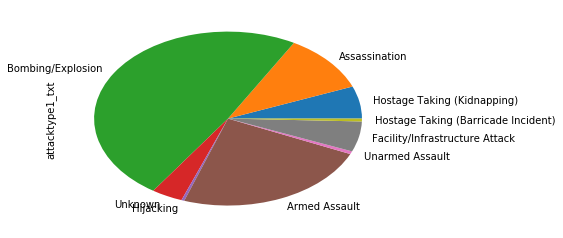

In [19]:
#AttackType
gt_data_for_viz["attacktype1_txt"].value_counts(sort=False).plot.pie()
plt.show()

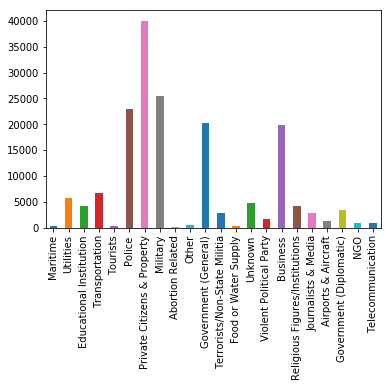

In [20]:
#Targ Type
gt_data_for_viz["targtype1_txt"].value_counts(sort=False).plot(kind="bar")
plt.show()

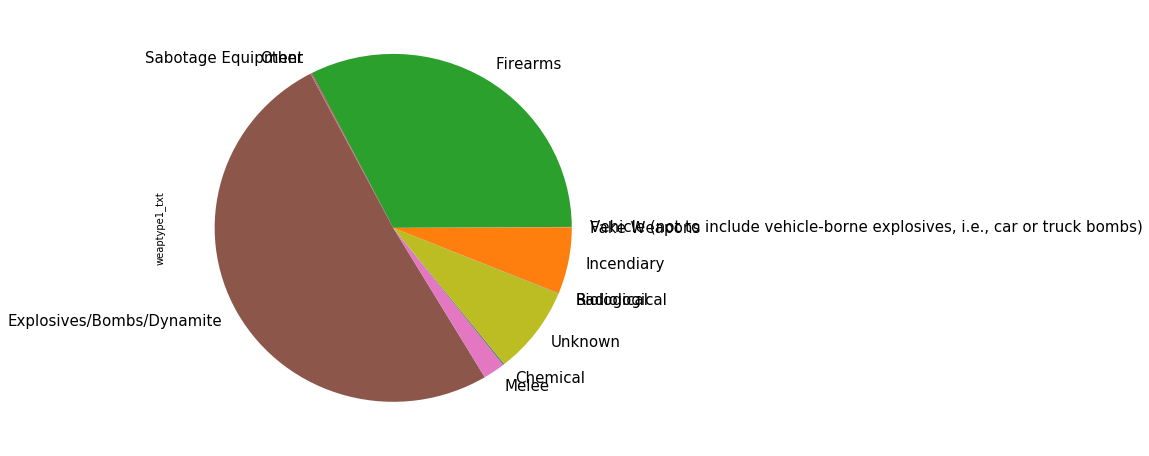

In [21]:
#Weapon Type
gt_data_for_viz["weaptype1_txt"].value_counts(sort=False).plot.pie(figsize=(8, 8),fontsize=15)
plt.show()

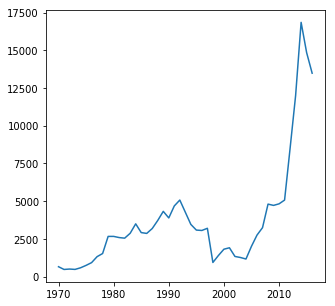

In [22]:
#Recorded Terrorist Incidents per year
gt_data_for_viz["iyear"].value_counts().sort_index().plot(figsize=(5, 5))
plt.show()

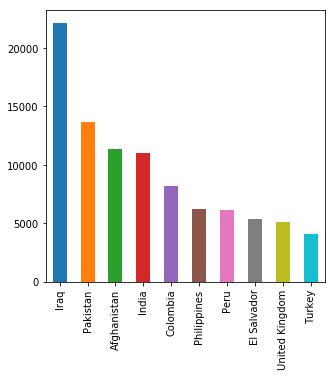

In [23]:
#Top 10 Recorded Terrorist Incidents per country
gt_data_for_viz["country_txt"].value_counts().head(10).plot(kind="bar",figsize=(5, 5))
plt.show()

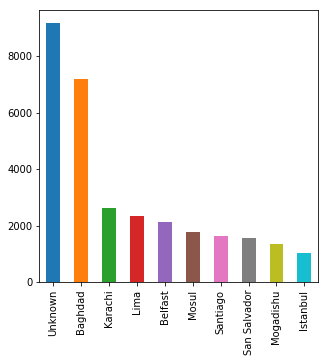

In [24]:
#Top 10 Recorded Terrorist Incidents per city
gt_data_for_viz["city"].value_counts().head(10).plot(kind="bar",figsize=(5, 5))
plt.show()

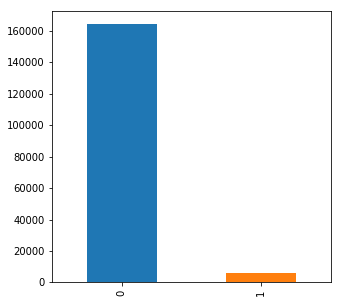

In [25]:
#Incidents resulting in Suicide
gt_data_for_viz["suicide"].value_counts().plot(kind="bar",figsize=(5, 5))
plt.show()

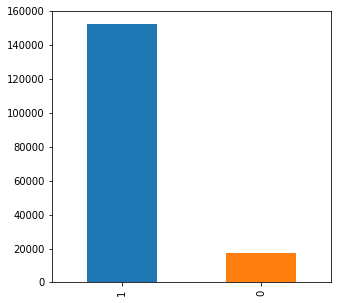

In [26]:
#Succesful
gt_data_for_viz["success"].value_counts().plot(kind="bar",figsize=(5, 5))
plt.show()

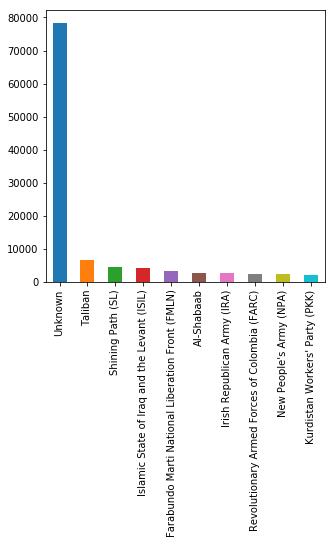

In [27]:
#Top 10 Perpetrator Groups by incidents
gt_data_for_viz["gname"].value_counts().head(10).plot(kind="bar",figsize=(5, 5))
plt.show()

Note: With these visualizations, notice how features in the data can partition the data into smaller and unique subsets

# 3. Training and Testing Algorithms 
*  Initialized classifcation models (Decision Tree, KNN and Random Forest)
*  Trained classification models
*  Tested algorithms on random samples large and small

In [28]:
#Initialize Classifier Models
#Decision Tree, KNN, Random Forest
dtree_model = DecisionTreeClassifier(max_depth = 100)
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_hamming = KNeighborsClassifier(n_neighbors=1,p=2,metric="hamming")

## Why Decision Tree?
DT is a classification model which performs implicit feature selection and is not affected by non-linear relationships within the data. DTs create a set of rules based on the features of the data which is then used to determine the class of a test data point. Chose DT over random forest classification implementation because random forest is computationally expensive with our training data set.

In [29]:
#Training Algorithms
dtree_model.fit(training_data[predictor_factors],training_data["gname"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Why K-Nearest Neighbors?
KNN is a simple classification model that is highly dependent on the similarity between a test data point and a stored data point(the neighbor(s)) from the training data used in the model. There are multiple single class instances within our GTD dataset(e.g., One time terrorist groups, City's that have been attacked once, etc.). By setting the algorithm to classify the test data points based on the single most similar neighbor we should be able to classify those instances with high accuracy.

In [30]:
knn_model.fit(training_data[predictor_factors],training_data["gname"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [31]:
#decision tree test
dtree_predictions = dtree_model.predict(test_data[predictor_factors])

In [32]:
#Test Unknown
dtree_unknown = dtree_model.predict(test_unknown[predictor_factors])

In [33]:
#KNN test
knn_pred = knn_model.predict(test_data[predictor_factors])

In [34]:
#KNN Unknown
knn_unknown = knn_model.predict(test_unknown[predictor_factors])

# 4. Evaluating Models
* custom function for accuracy
* accuracy score
* hamming loss

In [35]:
print("Decision Tree: ")
print_results(dtree_predictions,test_data,"gname")
print("Accuracy Score: ",accuracy_score(test_data["gname"],dtree_predictions))
print("Hamming Loss: ",hamming_loss(test_data["gname"],dtree_predictions))

Decision Tree: 
Results:
Number of mislabeled points out of a total 136280 points : 8101, performance 94.06%
Accuracy Score:  0.940556207807
Hamming Loss:  0.0594437921925


In [36]:
print("Decision Tree Unknown: ")
print_results(dtree_unknown,test_unknown,"gname")
print("Accuracy Score: ",accuracy_score(test_unknown["gname"],dtree_unknown))
print("Hamming Loss: ",hamming_loss(test_unknown["gname"],dtree_unknown))

Decision Tree Unknown: 
Results:
Number of mislabeled points out of a total 78306 points : 1722, performance 97.80%
Accuracy Score:  0.978009347943
Hamming Loss:  0.0219906520573


In [37]:
print("KNN: ")
print_results(knn_pred,test_data,"gname")
print("Accuracy Score: ",accuracy_score(test_data["gname"],knn_pred))
print("Hamming Loss: ",hamming_loss(test_data["gname"],knn_pred))

KNN: 
Results:
Number of mislabeled points out of a total 136280 points : 10667, performance 92.17%
Accuracy Score:  0.921727326093
Hamming Loss:  0.0782726739067


In [38]:
print("KNN Unknown: ")
print_results(knn_unknown,test_unknown,"gname")
print("Accuracy Score: ",accuracy_score(test_unknown["gname"],knn_unknown))
print("Hamming Loss: ",hamming_loss(test_unknown["gname"],knn_unknown))

KNN Unknown: 
Results:
Number of mislabeled points out of a total 78306 points : 5334, performance 93.19%
Accuracy Score:  0.931882614359
Hamming Loss:  0.0681173856409


As noted above, there are several classes with single instances. To address these instances, I refrained from using k-fold cross-validation to determine model accuracy because we would have splits that wouldn't provide an accurate representation of all classes as they appear within the data.

I used a custom function in conjunction with built-in sci-kit learn classification metrics accuracy score, f1_score and haming loss. Didn't use Jaccard Similarity Score since it is equivalent to the accuracy score.

Testing purely unknown perpetrators the predictive model performed almost identically given a data set with a different class distribution.

# 5. Conclusion
In conclusion, we are able to construct a fairly accurate predictive model that can determine the perpetrator group related to an incident. By selecting and engineering the right features we are able to construct a model with upwards of 90% accuracy and downwards of 10% hamming loss.